# 3D classification example based on DenseNet

This tutorial shows an example of 3D classification task based on DenseNet and array format transforms.

Here, the task is given to classify MR images into male/female.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/master/3d_classification/torch/densenet_training_array.ipynb)

## Setup environment

In [15]:
! python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
! pip install -q IProgress


## Setup imports

In [1]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
import time
import logging
import os
import sys
import shutil
import tempfile

import matplotlib.pyplot as plt
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np

import monai
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import DataLoader, ImageDataset
from monai.transforms import (
    AddChannel,
    Compose,
    RandRotate90,
    Resize,
    ScaleIntensity,
    EnsureType
)

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
# print_config()

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# set this in your environment or previous cell to wherever IXI is downloaded and extracted
RunFolder = "/HippoDense/runFolder"
DatasetDir = "/Datasets/01_P_Classification_all_hippo"
Labels = []
Images = []
NotFitImages = []
for root, dirs, files in os.walk(os.path.abspath(DatasetDir)):
    for file in files:
        if file.split("_")[-3] == "L":
            Labels.append(2)
            Images.append(os.path.join(root, file))
        elif file.split("_")[-3] == "E":
            Labels.append(1)
            Images.append(os.path.join(root, file))
        elif file.split("_")[-2] == "Normal":
            Labels.append(0)
            Images.append(os.path.join(root, file))
        elif file.split("_")[-2] == "Dementia":
            Labels.append(3)
            Images.append(os.path.join(root, file))
        else:
            NotFitImages.append(file)
            # print(file)
print("{}: images cannot be used.".format(len(NotFitImages)))
# # labels = np.load(
#     '/workspace/monai/MONAI-tutorials/3d_classification/01_P_Classification_all_labels.npy')
NumClasses = len(np.unique(Labels))
# ClassLabels = np.array(Labels)
if len(Images)==len(Labels):
    print("{}: total images prepared with {} different classes".format(len(Images), NumClasses))
# images


2: images cannot be used.
364: total images prepared with 4 different classes


In [19]:
torch.as_tensor(Labels).unique()

tensor([0, 1, 2, 3])

In [4]:

# Represent labels in one-hot format for binary classifier training,
# BCEWithLogitsLoss requires target to have same shape as input
pin_memory = torch.cuda.is_available()

labels = torch.nn.functional.one_hot(torch.as_tensor(Labels)).float()
print(labels.shape)
# Define transforms
train_transforms = Compose([ScaleIntensity(), AddChannel(), Resize((224, 256, 208)), RandRotate90(), EnsureType()])
# train_transforms = Compose([ScaleIntensity(), AddChannel(), EnsureType()])

val_transforms = Compose(
    [ScaleIntensity(), AddChannel(), Resize((224, 256, 208)), EnsureType()])
# val_transforms = Compose(
    # [ScaleIntensity(), AddChannel(), EnsureType()])

# Define nifti dataset, data loader
check_ds = ImageDataset(image_files=Images, labels=labels, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1, num_workers=64, pin_memory=pin_memory)

im, label = monai.utils.misc.first(check_loader)
print(type(im), im.shape, label, label.shape)



torch.Size([364, 4])
<class 'torch.Tensor'> torch.Size([1, 1, 256, 224, 208]) tensor([[0., 0., 1., 0.]]) torch.Size([1, 4])


In [5]:
# create a training data loader
train_ds = ImageDataset(image_files=Images[:-66], labels=labels[:-66], transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=64, pin_memory=pin_memory)

# create a validation data loader
val_ds = ImageDataset(image_files=Images[-66:], labels=labels[-66:], transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=32, pin_memory=pin_memory)

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for batch_data in train_loader:
    inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
    print(inputs.shape, labels.shape)
    break
for val_data in val_loader:
    val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
    print(val_images.shape, val_labels.shape)
    print(val_labels)
    break

torch.Size([1, 1, 224, 256, 208]) torch.Size([1, 4])
torch.Size([1, 1, 224, 256, 208]) torch.Size([1, 4])
tensor([[0., 0., 1., 0.]], device='cuda:0')


In [22]:
# Create DenseNet121, CrossEntropyLoss and Adam optimizer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
"""
Args:
        spatial_dims: number of spatial dimensions of the input image.
        in_channels: number of the input channel.
        out_channels: number of the output classes.
        init_features: number of filters in the first convolution layer.
        growth_rate: how many filters to add each layer(k in paper).
        block_config: how many layers in each pooling block.
        bn_size: multiplicative factor for number of bottle neck layers.
            (i.e. bn_size * k features in the bottleneck layer)
        act: activation type and arguments. Defaults to relu.
        norm: feature normalization type and arguments. Defaults to batch norm.
        dropout_prob: dropout rate after each dense layer.
"""

model = monai.networks.nets.DenseNet121(
    spatial_dims=3, in_channels=1, out_channels=NumClasses).to(device)

# loss_function = torch.nn.CrossEntropyLoss()
loss_function = torch.nn.BCEWithLogitsLoss()  # also works with this data

optimizer = torch.optim.Adam(model.parameters(), 1e-4)

# start a typical PyTorch training
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()
max_epochs = 300

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0

    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        writer.add_scalar(" - train_loss", loss.item(), epoch_len * epoch + step)

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()

        num_correct = 0.0
        metric_count = 0
        for val_data in val_loader:
            val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
            with torch.no_grad():
                val_outputs = model(val_images)
                value = torch.eq(val_outputs.argmax(dim=1), val_labels.argmax(dim=1))
                metric_count += len(value)
                num_correct += value.sum().item()

        metric = num_correct / metric_count
        metric_values.append(metric)

        if metric > best_metric:
            best_metric = metric
            best_metric_epoch = epoch + 1
            timeNow = time.strftime("%Y%m%d_%H%M%S")
            bestModelPath = os.path.join(RunFolder, "best_metric_model_classification3d_array" + timeNow + ".pth")
            torch.save(model.state_dict(), bestModelPath)
            print("saved new best metric model")

        print(f"Current epoch: {epoch+1} current accuracy: {metric:.4f} ")
        print(f"Best accuracy: {best_metric:.4f} at epoch {best_metric_epoch}")
        writer.add_scalar("val_accuracy", metric, epoch + 1)

print(f"Training completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
writer.close()
import pickle
with open('clf.pickle', 'wb') as f:
    pickle.dump(model, f)

----------
epoch 1/300
1/298, train_loss: 0.7066
2/298, train_loss: 0.7412
3/298, train_loss: 0.6466
4/298, train_loss: 0.6935
5/298, train_loss: 0.6751
6/298, train_loss: 0.6515
7/298, train_loss: 0.6845
8/298, train_loss: 0.6100
9/298, train_loss: 0.5896
10/298, train_loss: 0.5718
11/298, train_loss: 0.5506
12/298, train_loss: 0.5328
13/298, train_loss: 0.6586
14/298, train_loss: 0.6545
15/298, train_loss: 0.4865
16/298, train_loss: 0.6405
17/298, train_loss: 0.6281
18/298, train_loss: 0.4723
19/298, train_loss: 0.4838
20/298, train_loss: 0.6827
21/298, train_loss: 0.5901
22/298, train_loss: 0.4631
23/298, train_loss: 0.4446
24/298, train_loss: 0.4428
25/298, train_loss: 0.4281
26/298, train_loss: 0.5773
27/298, train_loss: 0.4108
28/298, train_loss: 0.4222
29/298, train_loss: 0.3945
30/298, train_loss: 0.3923
31/298, train_loss: 0.7225
32/298, train_loss: 0.7238
33/298, train_loss: 0.5940
34/298, train_loss: 0.6004
35/298, train_loss: 0.7019
36/298, train_loss: 0.5914
37/298, train_

positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.


1/298, train_loss: 1.2945
2/298, train_loss: 0.3011
3/298, train_loss: 0.2959
4/298, train_loss: 0.2923
5/298, train_loss: 0.2861
6/298, train_loss: 0.2782
7/298, train_loss: 0.5107
8/298, train_loss: 0.5144
9/298, train_loss: 0.2646
10/298, train_loss: 0.2631
11/298, train_loss: 0.2579
12/298, train_loss: 0.2561
13/298, train_loss: 0.2484
14/298, train_loss: 0.5580
15/298, train_loss: 0.5626
16/298, train_loss: 1.0083
17/298, train_loss: 0.2396
18/298, train_loss: 0.2386
19/298, train_loss: 0.2375
20/298, train_loss: 1.1720
21/298, train_loss: 0.2327
22/298, train_loss: 0.5852
23/298, train_loss: 0.2343
24/298, train_loss: 0.2311
25/298, train_loss: 0.9884
26/298, train_loss: 0.2293
27/298, train_loss: 0.6040
28/298, train_loss: 0.6012
29/298, train_loss: 0.2306
30/298, train_loss: 0.6014
31/298, train_loss: 0.2335
32/298, train_loss: 0.2374
33/298, train_loss: 0.9547
34/298, train_loss: 0.2397
35/298, train_loss: 0.2383
36/298, train_loss: 0.2395
37/298, train_loss: 0.9372
38/298, tr

In [20]:
labels

tensor([[0., 1., 0., 0., 0.]], device='cuda:0')

# Occlusion sensitivity
One method for trying to visualise why the network made a given prediction is occlusion sensitivity. We occlude part of the image, and see how the probability of a given prediction changes. We then iterate over the image, moving the occluded portion as we go, and in doing so we build up a sensitivity map detailing which areas were the most important in making the decision.

#### Bounds
If we were to test the occlusion centred on all voxels in our image, we would have to do `torch.prod(im.shape) = 96^3 = ~1e6` predictions. We can use the bounding box to only to the estimations in a region of interest, for example over one slice.

To do this, we simply give the bounding box as `(minC,maxC,minD,maxD,minH,maxH,minW,maxW)`. We can use `-1` for any value to use its full extent (`0` and `im.shape-1` for min's and max's, respectively).

#### Output
The output image in this example will look fairly bad, since our network hasn't been trained for very long. Training for longer should improve the quality of the occlusion map.

In [15]:
modelPath = "/workspace/monai/run_3d_classification/best_metric_model_classification3d_array20220415_063943.pt"
model = torch.load(modelPath)

In [16]:
# create a validation data loader
test_ds = ImageDataset(image_files=images[-10:], labels=labels[-10:], transform=val_transforms)
test_loader = DataLoader(val_ds, batch_size=1, num_workers=2, pin_memory=torch.cuda.is_available())
itera = iter(test_loader)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def get_next_im():
    test_data = next(itera)
    return test_data[0].to(device), test_data[1].unsqueeze(0).to(device)


def plot_occlusion_heatmap(im, heatmap):
    plt.subplots(1, 2)
    plt.subplot(1, 2, 1)
    plt.imshow(np.squeeze(im.cpu()))
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.imshow(heatmap)
    plt.colorbar()
    plt.show()

In [17]:
# Get a random image and its corresponding label
img, label = get_next_im()
# plt.imshow(img)

In [22]:
label


tensor([[[1., 0., 0., 0.]]], device='cuda:0')

Computing occlusion sensitivity: 100%|██████████| 53248/53248 [22:17<00:00, 39.82it/s]


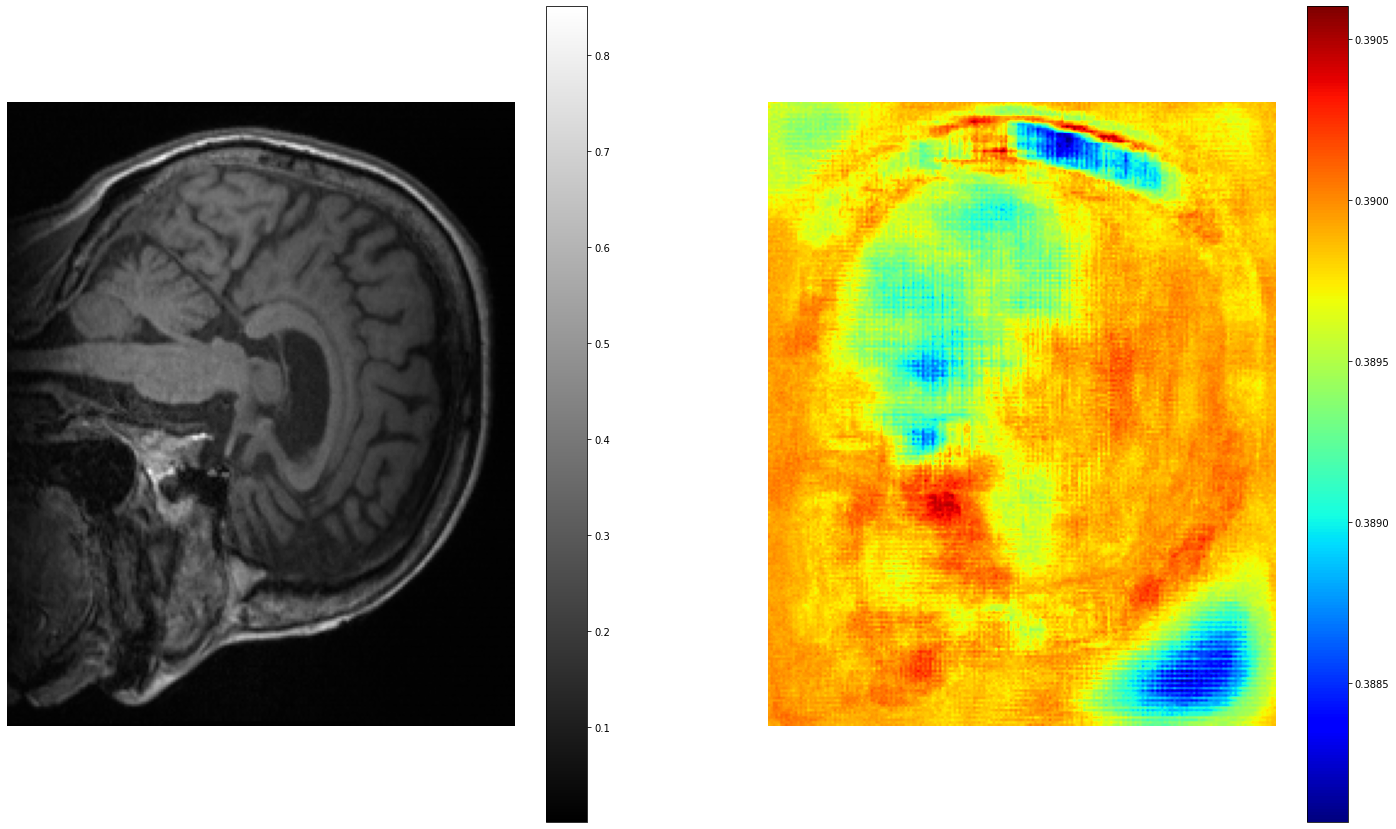

In [19]:
# Get the occlusion sensitivity map
occ_sens = monai.visualize.OcclusionSensitivity(nn_module=model,  n_batch=10)
# Only get a single slice to save time.
# For the other dimensions (channel, width, height), use
# -1 to use 0 and img.shape[x]-1 for min and max, respectively
depth_slice = img.shape[2] // 2
occ_sens_b_box = [-1, -1, depth_slice, depth_slice, -1, -1, -1, -1]

occ_result, _ = occ_sens(x=img, b_box=occ_sens_b_box)
occ_result = occ_result[..., label.argmax().item()]

fig, axes = plt.subplots(1, 2, figsize=(25, 15), facecolor="white")

for i, im in enumerate([img[:, :, depth_slice, ...], occ_result]):
    cmap = "gray" if i == 0 else "jet"
    ax = axes[i]
    im_show = ax.imshow(np.squeeze(im[0][0].detach().cpu()), cmap=cmap)
    ax.axis("off")
    fig.colorbar(im_show, ax=ax)

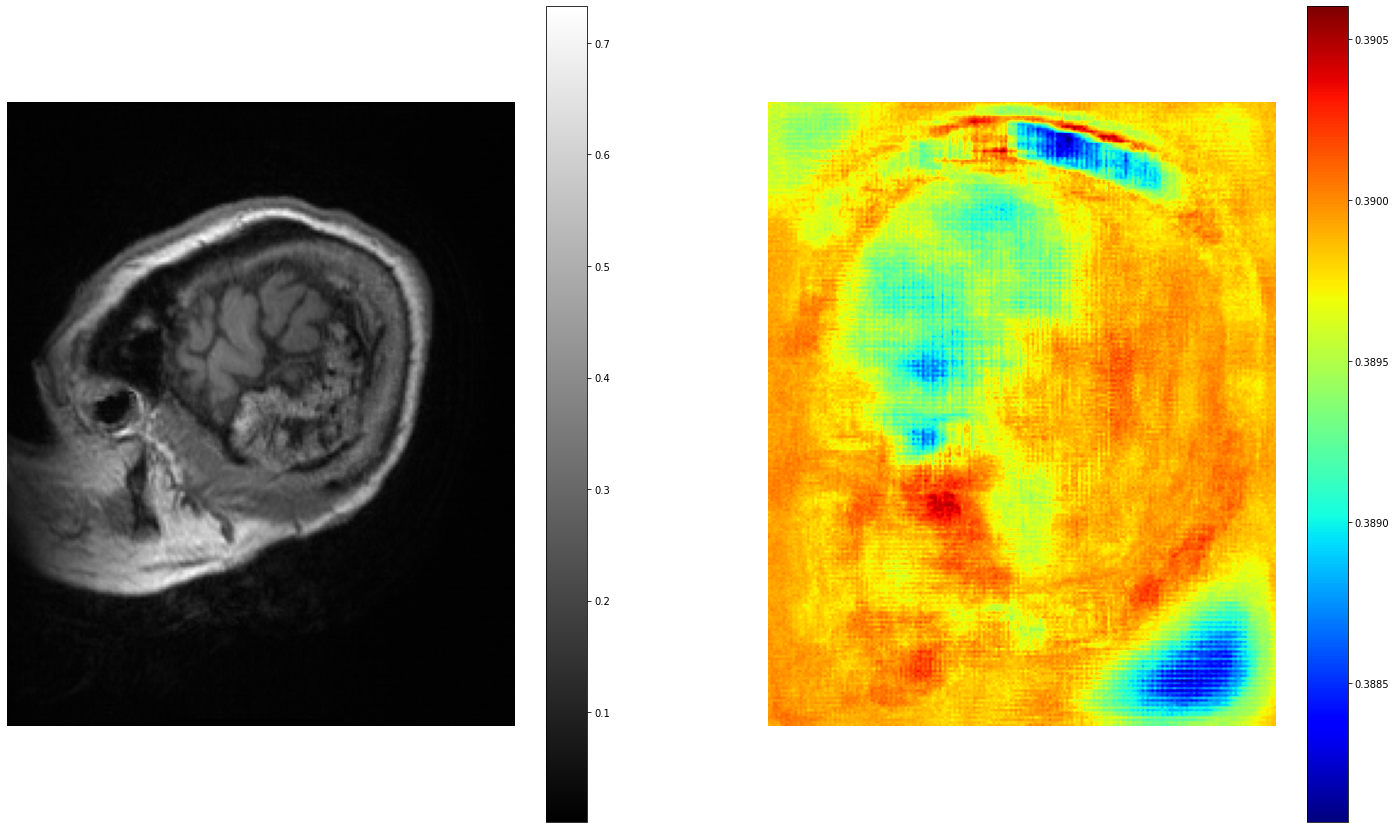

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(25, 15), facecolor="white")

for i, im in enumerate([img[:, :, 50, ...], occ_result]):
    cmap = "gray" if i == 0 else "jet"
    ax = axes[i]
    im_show = ax.imshow(np.squeeze(im[0][0].detach().cpu()), cmap=cmap)
    ax.axis("off")
    fig.colorbar(im_show, ax=ax)


## Cleanup data directory

Remove directory if a temporary was used.

In [9]:
if directory is None:
    shutil.rmtree(root_dir)